In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.math import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
from pandarallel import pandarallel
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.ensemble import RandomForestClassifier
import optuna
import sklearn
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import pickle
from sklearn.neural_network import MLPClassifier

# <span style="color:purple"> LEITURA DATASET </span>

In [2]:
columns = [i for i in range(0, 63)]
columns.extend(["classe", "signer"])
dataset = pd.read_csv('dataset_v3.csv')
dataset.columns = columns
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,classe,signer
0,-0.017227,0.074167,0.028766,0.013955,0.058635,0.009331,0.039599,0.031790,0.008871,0.050059,...,-0.002371,-0.023715,-0.027515,0.010693,-0.039081,-0.027290,0.030310,-0.033299,a,1
1,-0.018473,0.077650,0.041800,0.014967,0.061603,0.021215,0.038178,0.035501,0.016030,0.050092,...,-0.003565,-0.024832,-0.028658,0.008516,-0.039817,-0.029420,0.025273,-0.032277,a,1
2,-0.017608,0.076486,0.024926,0.014930,0.061257,0.009007,0.040645,0.035219,0.006765,0.051121,...,-0.005195,-0.026848,-0.029004,0.009567,-0.043633,-0.029709,0.025901,-0.034032,a,1
3,-0.017949,0.074026,0.025973,0.014371,0.061371,0.008799,0.041199,0.034858,0.007288,0.053026,...,-0.006043,-0.025303,-0.028130,0.008016,-0.042826,-0.029535,0.025131,-0.035854,a,1
4,-0.019782,0.073851,0.022678,0.013184,0.060462,0.003672,0.040342,0.034172,0.004060,0.050691,...,-0.006673,-0.024682,-0.028794,0.006464,-0.041332,-0.029523,0.025261,-0.036269,a,1


In [3]:
len(dataset.index)

17309

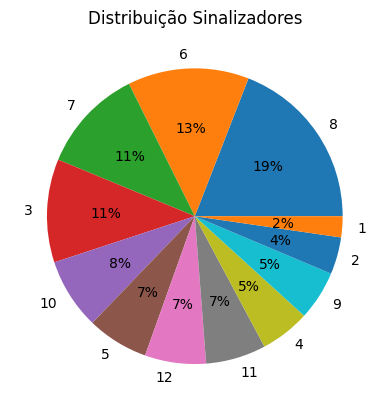

In [4]:
signer_data = dataset['signer'].value_counts()
plt.title('Distribuição Sinalizadores')
_ = plt.pie(signer_data, labels=signer_data.index, autopct='%.0f%%')

In [130]:
signers_train = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
signers_test = [3]

In [131]:
classes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'i', 'l', 'm', 'n', 'o', 'p',
        'q', 'r', 's', 't', 'u', 'v', 'w', 'y']

In [132]:
le = preprocessing.LabelEncoder()
le.fit(classes)

LabelEncoder()

In [133]:
dataset_train = dataset.loc[dataset['signer'].isin(signers_train)]

In [134]:
feats = [i for i in range(0, 63)]

X_train = np.array(dataset_train[feats])
Y_train = np.array(le.transform(dataset_train['classe']))

#X_train = preprocessing.normalize(X_train)

In [135]:
dataset_test = dataset.loc[dataset['signer'].isin(signers_test)]

In [136]:
X_test = np.array(dataset_test[feats])
Y_test = np.array(le.transform(dataset_test['classe']))

#X_test = preprocessing.normalize(X_test)

# <span style="color:purple"> ANÁLISE DO DATASET</span>

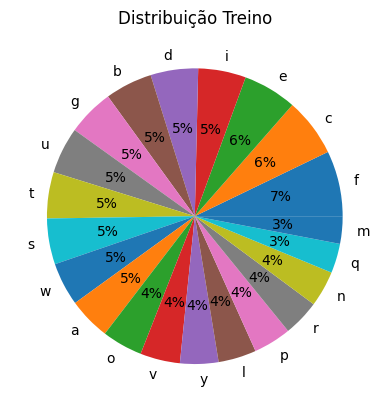

In [137]:
data = dataset_train['classe'].value_counts()
plt.title('Distribuição Treino')
_ = plt.pie(data, labels=data.index, autopct='%.0f%%')

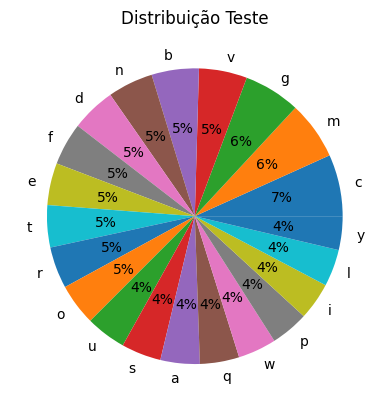

In [138]:
data = dataset_test['classe'].value_counts()
plt.title('Distribuição Teste')
_ = plt.pie(data, labels=data.index, autopct='%.0f%%')

In [139]:
X_train.shape, X_test.shape

((15354, 63), (1955, 63))

# <span style="color:purple"> SVM </span>

In [140]:
model = svm.SVC(decision_function_shape='ovo')

In [141]:
model.fit(X_train, Y_train)

SVC(decision_function_shape='ovo')

In [142]:
pred = model.predict(X_test)

In [143]:
print(classification_report(Y_test, pred, target_names=classes))

              precision    recall  f1-score   support

           a       1.00      1.00      1.00        84
           b       1.00      1.00      1.00       101
           c       1.00      1.00      1.00       132
           d       0.99      1.00      0.99        95
           e       1.00      1.00      1.00        90
           f       1.00      1.00      1.00        91
           g       1.00      1.00      1.00       121
           i       1.00      0.97      0.99        80
           l       1.00      1.00      1.00        79
           m       1.00      1.00      1.00       124
           n       1.00      1.00      1.00        97
           o       1.00      1.00      1.00        89
           p       1.00      1.00      1.00        81
           q       1.00      1.00      1.00        84
           r       1.00      0.99      0.99        89
           s       1.00      1.00      1.00        85
           t       1.00      1.00      1.00        90
           u       1.00    

<AxesSubplot:>

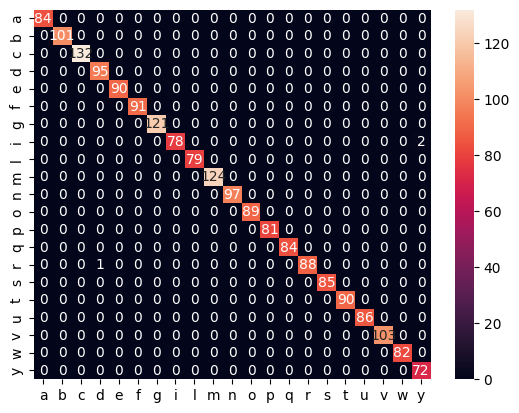

In [144]:
cm = confusion_matrix(Y_test, pred)

df_cm = pd.DataFrame(np.array(cm), columns=classes, index=classes)
sns.heatmap(df_cm, annot=True, fmt=".0f")

# <span style="color:purple"> OPTUNA (in case for hyperparameter tuning) </span>

In [109]:
def objective(trial):
    
    gamma = trial.suggest_float('gamma', 0.0001, 10)
    c = trial.suggest_float('c', 0.1, 100)
    
    clf = svm.SVC(decision_function_shape='ovo', C=c, gamma=gamma)
    
    return sklearn.model_selection.cross_val_score(
        clf, X_train, Y_train, n_jobs=-1, cv=3).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-03-14 01:51:44,222] A new study created in memory with name: no-name-aab3b695-cbd6-49bb-a603-670b924ae3d9
[I 2023-03-14 01:51:47,063] Trial 0 finished with value: 0.9542138856324085 and parameters: {'gamma': 6.270270892348803, 'c': 50.75125108926076}. Best is trial 0 with value: 0.9542138856324085.
[I 2023-03-14 01:51:48,762] Trial 1 finished with value: 0.9550605705353655 and parameters: {'gamma': 6.010569478458436, 'c': 44.17069929075248}. Best is trial 1 with value: 0.9550605705353655.
[I 2023-03-14 01:51:49,851] Trial 2 finished with value: 0.9534323303373714 and parameters: {'gamma': 8.05660972383991, 'c': 46.36277093010797}. Best is trial 1 with value: 0.9550605705353655.
[I 2023-03-14 01:51:51,171] Trial 3 finished with value: 0.9553862185749642 and parameters: {'gamma': 9.117317559883148, 'c': 13.081918321330267}. Best is trial 3 with value: 0.9553862185749642.
[I 2023-03-14 01:51:54,089] Trial 4 finished with value: 0.9430115930702097 and parameters: {'gamma': 3.560662

Accuracy: 0.959489383873909
Best hyperparameters: {'gamma': 2.1639852923469776, 'c': 90.96024369708432}


In [110]:
final_model = svm.SVC(decision_function_shape='ovo', gamma=trial.params['gamma'], C=trial.params['c'], probability=True)

In [111]:
final_model.fit(X_train, Y_train)

SVC(C=90.96024369708432, decision_function_shape='ovo',
    gamma=2.1639852923469776, probability=True)

In [112]:
pred = model.predict(X_test)

In [113]:
print(classification_report(Y_test, pred, target_names=classes))

              precision    recall  f1-score   support

           a       1.00      1.00      1.00        84
           b       1.00      1.00      1.00       101
           c       1.00      1.00      1.00       132
           d       0.99      1.00      0.99        95
           e       1.00      1.00      1.00        90
           f       1.00      1.00      1.00        91
           g       1.00      1.00      1.00       121
           i       1.00      0.97      0.99        80
           l       1.00      1.00      1.00        79
           m       1.00      1.00      1.00       124
           n       1.00      1.00      1.00        97
           o       1.00      1.00      1.00        89
           p       1.00      1.00      1.00        81
           q       1.00      1.00      1.00        84
           r       1.00      0.99      0.99        89
           s       1.00      1.00      1.00        85
           t       1.00      1.00      1.00        90
           u       1.00    

# <span style="color:purple"> CONVERT TO ONNX </span>

Onnx models can run inferences on mobile devices.

In [135]:
initial_type = [ 
    ( 'input_landmarks' , FloatTensorType( [None,63] ) ) 
]

converted_model = convert_sklearn(final_model, initial_types=initial_type)

with open( "alphabet_model.onnx", "wb" ) as f:
        f.write( converted_model.SerializeToString() )

# <span style="color:purple"> TESTS </span>

In [112]:
acc = []

for i in range(1, 13):
    signers_train = [j for j in range(1, 13) if j != i]
    signers_test = [i]
    
    dataset_train = dataset.loc[dataset['signer'].isin(signers_train)]
    
    feats = [i for i in range(0, 63)]

    X_train = np.array(dataset_train[feats])
    Y_train = np.array(le.transform(dataset_train['classe']))
    
    dataset_test = dataset.loc[dataset['signer'].isin(signers_test)]
    
    X_test = np.array(dataset_test[feats])
    Y_test = np.array(le.transform(dataset_test['classe']))
    
    model = svm.SVC(decision_function_shape='ovo')
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    
    report = classification_report(Y_test, pred, output_dict=True, zero_division=0)
    acc.append(report['accuracy'])

In [116]:
acc.sort()
acc

[0.8901960784313725,
 0.907051282051282,
 0.9302925989672978,
 0.9386590584878745,
 0.9542978208232445,
 0.9544303797468354,
 0.957286432160804,
 0.9851222104144527,
 0.9853068280034573,
 0.9938542581211589,
 0.99846547314578,
 0.9985141158989599]